In [ ]:
import matplotlib.pyplot as plt
import os

from google.colab import drive
from glob import glob
from PIL import Image
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


## 1 - Carga de datos

En este paso montamos Google Drive para acceder al dataset y exploramos su estructura con el fin de confirmar que contiene las carpetas cats y dogs, organizadas correctamente por clases. Esto es esencial para usar flow_from_directory().

In [2]:
# Montamos google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Exploramos el contenido

ruta_base = "/content/drive/MyDrive/dataset"

def contar_jpg(ruta):
    return len([f for f in os.listdir(ruta) if f.lower().endswith('.jpg')]) if os.path.isdir(ruta) else 0

for root, dirs, files in os.walk(ruta_base):
    nivel = root.replace(ruta_base, '').count(os.sep)
    sangria = '  ' * nivel
    nombre_carpeta = os.path.basename(root)
    total_jpg = contar_jpg(root)
    print(f"{sangria}{nombre_carpeta}/ ({total_jpg} imágenes)")

dataset/ (0 imágenes)
  dogs_vs_cats/ (0 imágenes)
    test/ (0 imágenes)
      cats/ (2500 imágenes)
      dogs/ (2500 imágenes)
    train/ (0 imágenes)
      cats/ (10000 imágenes)
      dogs/ (10000 imágenes)
  test/ (0 imágenes)
    cats/ (2500 imágenes)
    dogs/ (2500 imágenes)
  train/ (0 imágenes)
    cats/ (10000 imágenes)
    dogs/ (10000 imágenes)


/content/drive/MyDrive/dataset/train/cats

/content/drive/MyDrive/dataset/train/dogs

## 2 - Preparar los generadores de imágenes

2.1 - Creamos los generadores de entrenamiento y validación a partir del directorio dataset/train.

- Aplicamos aumentos de datos al entrenamiento para mejorar la generalización.
- Reescalamos los valores de píxeles (rescale=1/255) para normalizar las imágenes.
- Definimos el tamaño de entrada: 128×128 píxeles.

In [4]:
ruta_train = "/content/drive/MyDrive/dataset/train"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

image_size = (128, 128)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    ruta_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    ruta_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


2.2 - Visualización de imagenes:

Verificamos visualmente que las imágenes estén bien cargadas desde el generador, que tienen el tamaño correcto, y que las etiquetas corresponden a su clase real (cats o dogs).


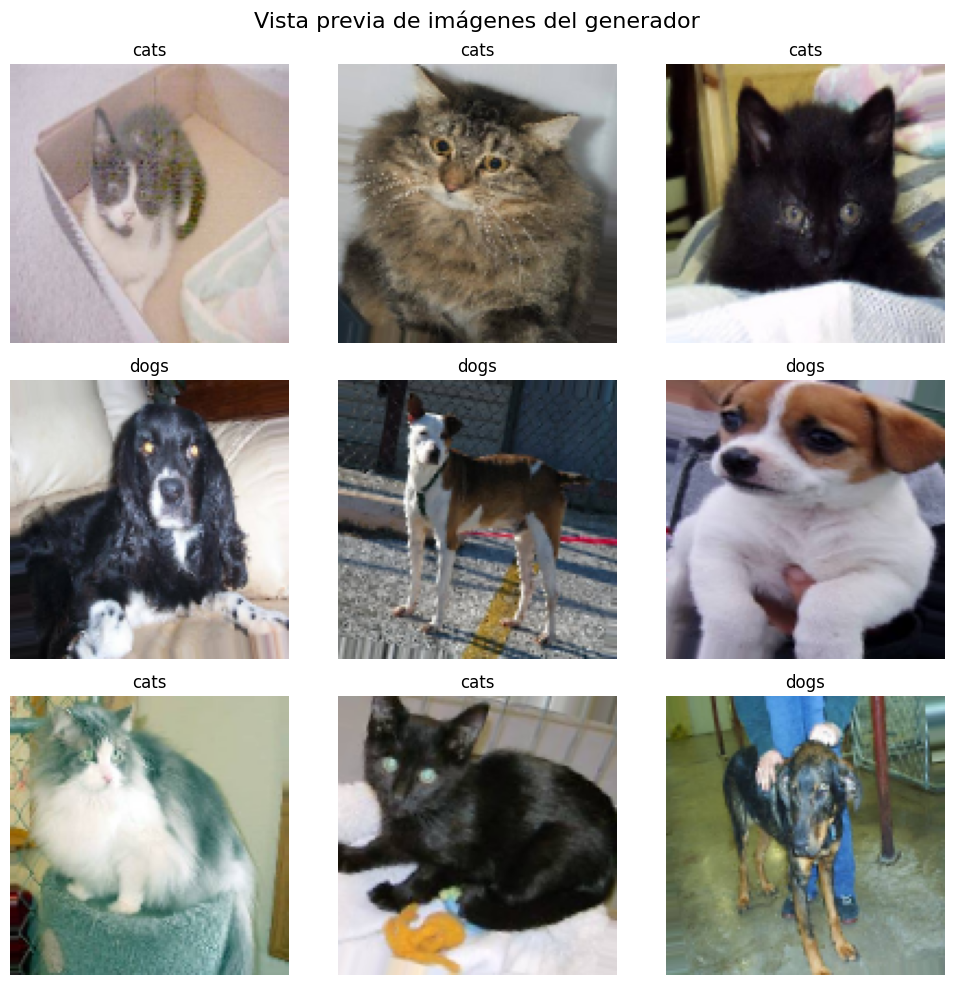

In [5]:
# Mostramos 9 imágenes de un batch del generador de entrenamiento
imagenes, etiquetas = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imagenes[i])
    clase = etiquetas[i].argmax()
    nombre_clase = list(train_generator.class_indices.keys())[clase]
    plt.title(nombre_clase)
    plt.axis('off')

plt.suptitle("Vista previa de imágenes del generador", fontsize=16)
plt.tight_layout()
plt.show()

## 3 - Definición de la arquitectura del modelo

Creamos una CNN ligera y eficiente, con 3 bloques convolucionales y una capa densa final. Esta estructura tiene aproximadamente 1 millón de parámetros y es adecuada para entrenar en Colab con imágenes 128×128.

In [6]:
model = Sequential()
model.add(Input(shape=(128, 128, 3)))  # Tamaño de imagen

# Bloque 1
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Bloque 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Bloque 3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Clasificación final
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Dos clases: cats y dogs

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,354 (4.09 MB)

 Trainable params: 1,072,354 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

## 4 – Compilar y entrenar el modelo

Usamos:

- categorical_crossentropy como función de pérdida porque hay 2 clases (gato y perro) y class_mode='categorical'.
- Adam con un learning rate bajo para una convergencia más estable.
- EarlyStopping para detener el entrenamiento si no hay mejoras.
- ModelCheckpoint para guardar el mejor modelo automáticamente.

In [7]:
# Compilamos el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks opcionales para mejor control del entrenamiento
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("mejor_modelo.h5", save_best_only=True)
]

# Entrenamos el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5464 - loss: 0.6814

500/500 ━━━━━━━━━━━━━━━━━━━━ 4113s 8s/step - accuracy: 0.5465 - loss: 0.6814 - val_accuracy: 0.6865 - val_loss: 0.5949
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6811 - loss: 0.5995

500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 270ms/step - accuracy: 0.6811 - loss: 0.5995 - val_accuracy: 0.7420 - val_loss: 0.5290
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - accuracy: 0.7251 - loss: 0.5517 - val_accuracy: 0.7295 - val_loss: 0.5469
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7299 - loss: 0.5427

500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 273ms/step - accuracy: 0.7299 - loss: 0.5427 - val_accuracy: 0.7615 - val_loss: 0.4933
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7494 - loss: 0.5160

500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 284ms/step - accuracy: 0.7494 - loss: 0.5160 - val_accuracy: 0.7728 - val_loss: 0.4745
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 270ms/step - accuracy: 0.7523 - loss: 0.5073 - val_accuracy: 0.7665 - val_loss: 0.4849
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7690 - loss: 0.4858

500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 269ms/step - accuracy: 0.7690 - loss: 0.4858 - val_accuracy: 0.7680 - val_loss: 0.4714
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7753 - loss: 0.4841

500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 283ms/step - accuracy: 0.7753 - loss: 0.4841 - val_accuracy: 0.7830 - val_loss: 0.4449
Epoch 9/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7859 - loss: 0.4706

500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 268ms/step - accuracy: 0.7859 - loss: 0.4705 - val_accuracy: 0.7940 - val_loss: 0.4342
Epoch 10/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7837 - loss: 0.4637

500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 271ms/step - accuracy: 0.7837 - loss: 0.4637 - val_accuracy: 0.7977 - val_loss: 0.4297
Epoch 11/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7856 - loss: 0.4545

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 285ms/step - accuracy: 0.7856 - loss: 0.4545 - val_accuracy: 0.8050 - val_loss: 0.4246
Epoch 12/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8051 - loss: 0.4299

500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 284ms/step - accuracy: 0.8051 - loss: 0.4299 - val_accuracy: 0.8062 - val_loss: 0.4142
Epoch 13/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - accuracy: 0.8108 - loss: 0.4221 - val_accuracy: 0.8058 - val_loss: 0.4158
Epoch 14/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8078 - loss: 0.4199

500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - accuracy: 0.8078 - loss: 0.4199 - val_accuracy: 0.8173 - val_loss: 0.4096
Epoch 15/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8150 - loss: 0.4166

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 281ms/step - accuracy: 0.8150 - loss: 0.4165 - val_accuracy: 0.8135 - val_loss: 0.4075


## 5 – Visualizar el rendimiento del entrenamiento

Representamos gráficamente la evolución de la precisión y la pérdida en entrenamiento y validación. Estas gráficas nos permiten detectar:

- Mejora continua → el modelo está aprendiendo.
- Divergencia entre entrenamiento y validación → posible sobreajuste.
- Estancamiento → tal vez aumentar complejidad o entrenar más épocas.

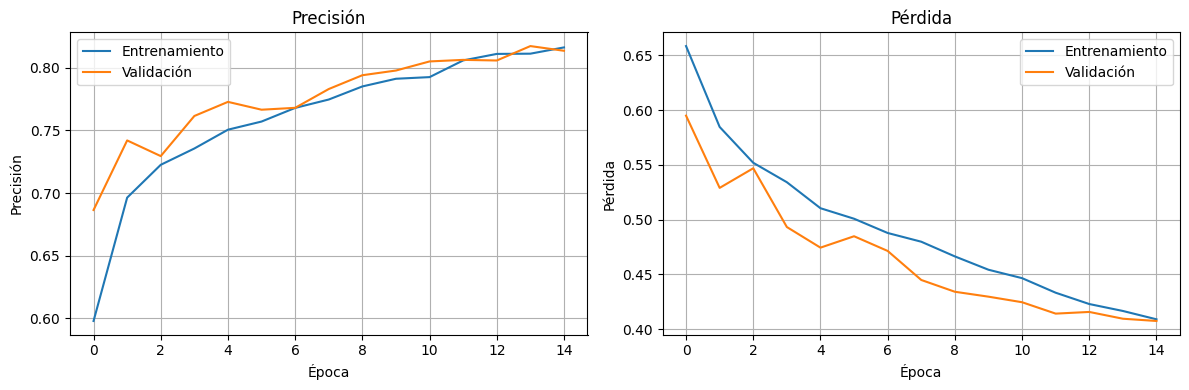

In [8]:
# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Análisis de las curvas de entrenamiento

Las gráficas muestran una evolución muy positiva del modelo:

- La precisión mejora de forma constante tanto en entrenamiento como en validación, y ambas curvas se mantienen muy cerca una de la otra, lo que indica bajo sobreajuste.
- La pérdida (loss) disminuye progresivamente en ambos conjuntos, con la de validación incluso siendo más baja que la de entrenamiento en varios momentos, lo cual es una señal de que el modelo generaliza bien.

Conclusión: el modelo ha aprendido a clasificar perros y gatos con solidez y estabilidad. La arquitectura ligera ha sido eficaz y el uso de EarlyStopping ha evitado sobreentrenamiento innecesario.

## 6 – Guardar el modelo entrenado

In [9]:
# Guardar el modelo entrenado en formato moderno de Keras
modelo_path = "/content/drive/MyDrive/perros_vs_gatos_v1.keras"
model.save(modelo_path)

print(f"Modelo guardado correctamente en:\n{modelo_path}")

Modelo guardado correctamente en:
/content/drive/MyDrive/perros_vs_gatos_v1.keras


## 7 – Evaluar el modelo sobre el conjunto de test

Una vez guardado el modelo entrenado, es fundamental evaluar su rendimiento sobre un conjunto de imágenes nunca vistas: el conjunto de test. Esto nos permitirá validar su capacidad de generalización y conocer sus métricas reales de desempeño. Para ello:

7.1 – Crear el generador para el conjunto de test
Creamos un nuevo ImageDataGenerator, similar al de entrenamiento pero sin aumentos de datos, ya que no queremos alterar las imágenes de test. Es esencial establecer shuffle=False para que las predicciones estén alineadas correctamente con las etiquetas reales.

In [10]:
# Creamos el generador para el conjunto de test
ruta_test = "/content/drive/MyDrive/dataset/test"
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    ruta_test,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Importante para evaluación correcta
)

Found 5000 images belonging to 2 classes.


7.2 – Cargar el modelo entrenado
Cargamos el modelo previamente guardado para usarlo en la predicción:

In [ ]:
# Cargamos el modelo guardado

modelo_path = "/content/drive/MyDrive/perros_vs_gatos_v1.keras"
modelo = load_model(modelo_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7.3 – Evaluar precisión y pérdida en test
Usamos el método .evaluate() para obtener la precisión y pérdida:

In [12]:
# Evaluamos precisión y pérdida en test
loss, accuracy = modelo.evaluate(test_generator)
print(f"Precisión en test: {accuracy*100:.2f}%")
print(f"Pérdida en test: {loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 990s 6s/step - accuracy: 0.8454 - loss: 0.3583
Precisión en test: 81.76%
Pérdida en test: 0.3991


### Análisis de los resultados:
El modelo ha alcanzado una precisión del 81.76% en el conjunto de test, lo cual indica que generaliza adecuadamente sobre imágenes nunca vistas. Además, la pérdida de 0.3991 refleja una buena capacidad del modelo para distinguir entre las clases sin grandes errores de probabilidad.

Estos resultados se encuentran alineados con el rendimiento observado en entrenamiento y validación, lo cual sugiere:

- Buena estabilidad del modelo, sin signos evidentes de sobreentrenamiento.

- Capacidad robusta de generalización para imágenes fuera del conjunto de entrenamiento.

- Rendimiento consistente en múltiples métricas, útil para aplicaciones reales como despliegue en apps o herramientas de clasificación.

7.4 – Matriz de confusión y reporte de clasificación para entender mejor qué clases se confunden y cómo se comporta el modelo por tipo de imagen:

In [13]:
# Reporte detallado y matriz de confusión (opcional)
predicciones = modelo.predict(test_generator)
clases_predichas = np.argmax(predicciones, axis=1)
clases_reales = test_generator.classes

print(confusion_matrix(clases_reales, clases_predichas))
print(classification_report(
    clases_reales,
    clases_predichas,
    target_names=list(test_generator.class_indices.keys()))
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step
[[2143  357]
 [ 555 1945]]
              precision    recall  f1-score   support

        cats       0.79      0.86      0.82      2500
        dogs       0.84      0.78      0.81      2500

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



### Analisis de los resultados:

La matriz de confusión muestra cuántas imágenes fueron clasificadas correctamente o incorrectamente por el modelo:
- De las 2500 imágenes de gatos, el modelo clasificó correctamente 2143 (true positives) y confundió 357 como perros.

- De las 2500 imágenes de perros, clasificó correctamente 1945 y confundió 555 como gatos.

La precisión promedio del modelo: 82% indican que el modelo:

- Tiene ligera mejor recall en gatos (detecta más gatos correctamente), pero mejor precisión en perros (los errores de perro son menos frecuentes).

- El F1-score equilibrado sugiere que el modelo trata ambas clases con una eficacia comparable, sin sesgo significativo.